1.3.2
d:\anaconda\envs\pytorch\python.exe
Epoch 1/150
41/41 [==============================] - 3s 46ms/step - loss: 0.2738 - val_loss: 0.2370 - lr: 0.0010
Epoch 2/150
41/41 [==============================] - 2s 39ms/step - loss: 0.1005 - val_loss: 0.4168 - lr: 0.0010
Epoch 3/150
41/41 [==============================] - 2s 42ms/step - loss: 0.0730 - val_loss: 0.2433 - lr: 0.0010
Epoch 4/150
41/41 [==============================] - 2s 43ms/step - loss: 0.0475 - val_loss: 0.2463 - lr: 0.0010
Epoch 5/150
41/41 [==============================] - 2s 43ms/step - loss: 0.0375 - val_loss: 0.1940 - lr: 0.0010
Epoch 6/150
41/41 [==============================] - 2s 43ms/step - loss: 0.0377 - val_loss: 0.2619 - lr: 0.0010
Epoch 7/150
41/41 [==============================] - 2s 43ms/step - loss: 0.0358 - val_loss: 0.2385 - lr: 0.0010
Epoch 8/150
41/41 [==============================] - 2s 44ms/step - loss: 0.0313 - val_loss: 0.2150 - lr: 0.0010
Epoch 9/150
41/41 [==============================] - 2

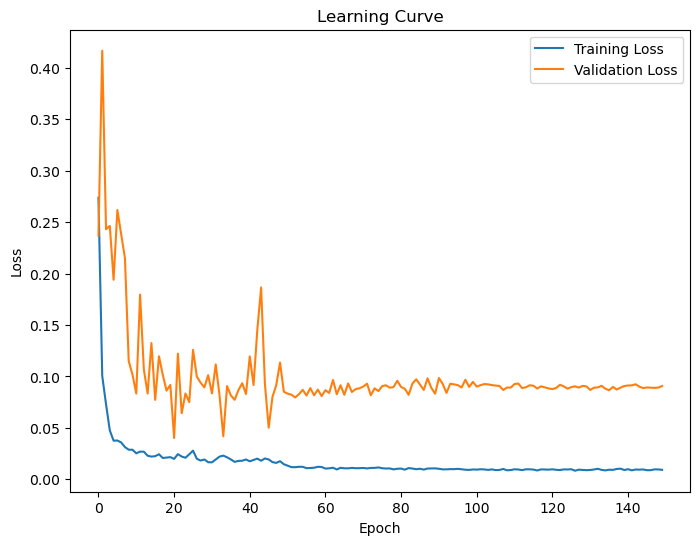

102/102 [==============================] - 3s 18ms/step


d:\anaconda\envs\pytorch\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


258/258 [==============================] - 4s 15ms/step
RMSE: 0.4130
MAE: 0.2519


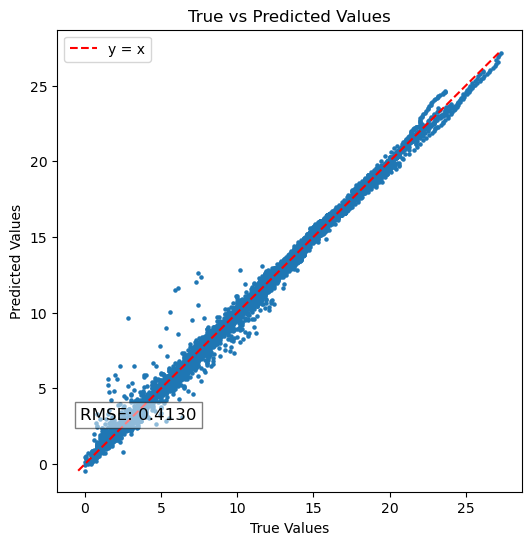

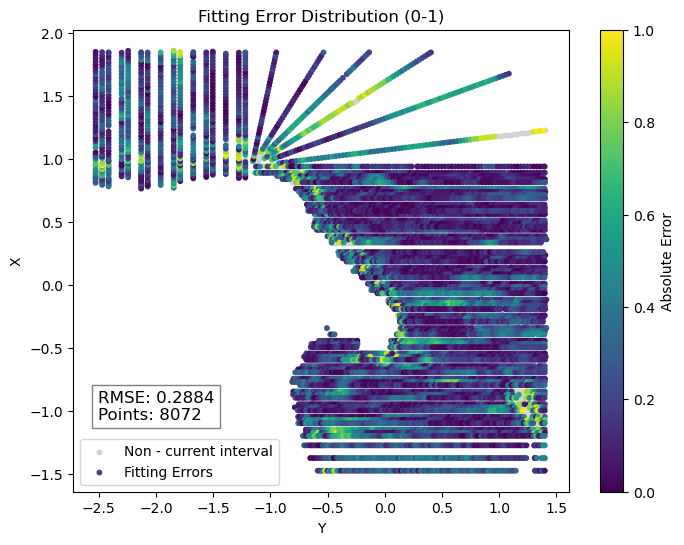

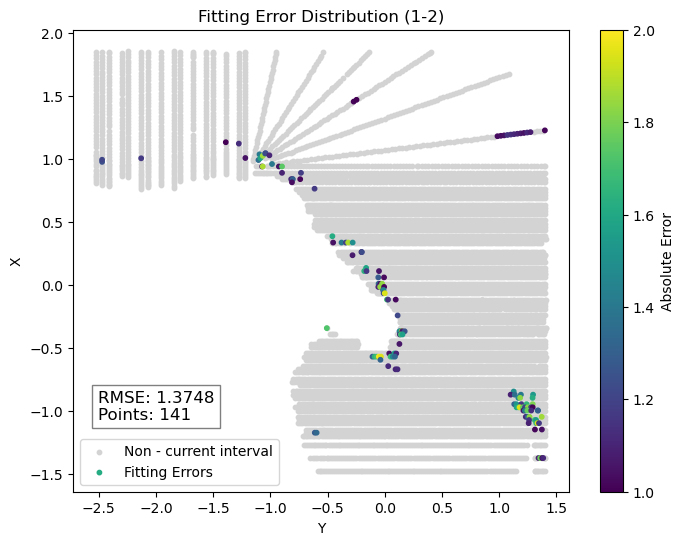

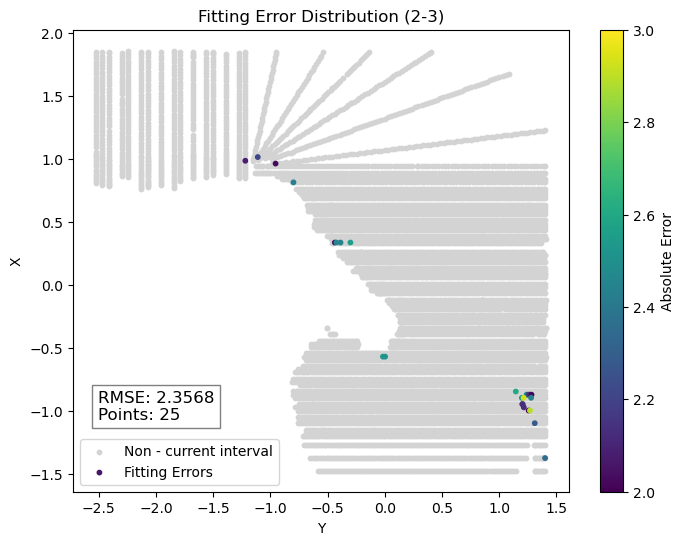

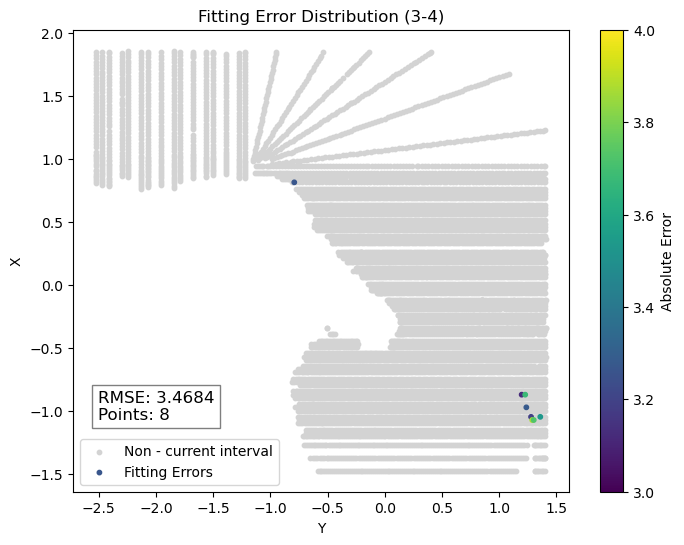

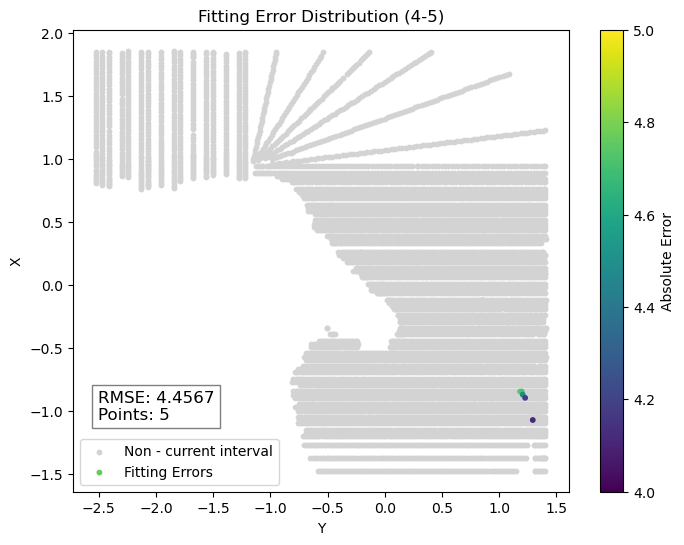

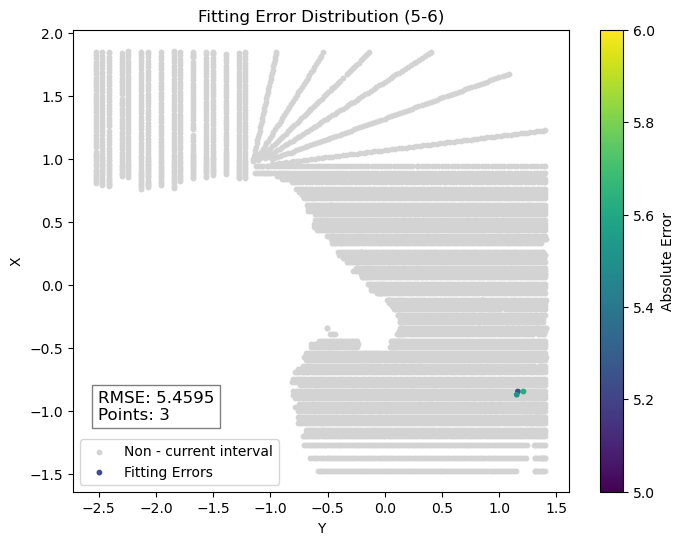

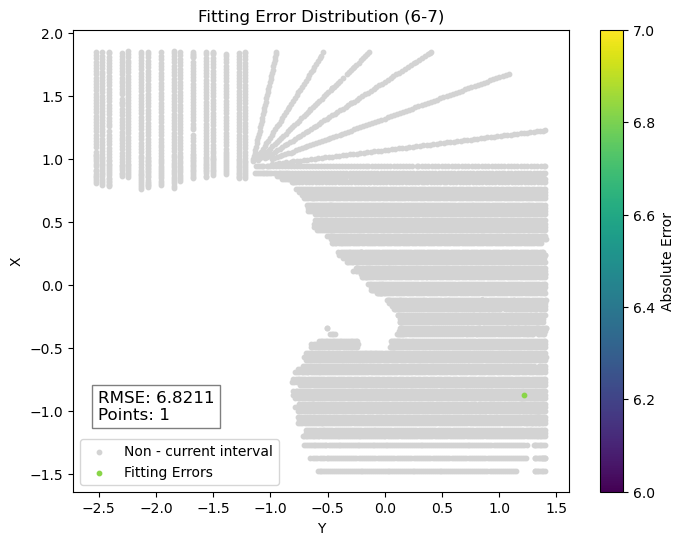

RMSE for gap 0-2: 0.3379


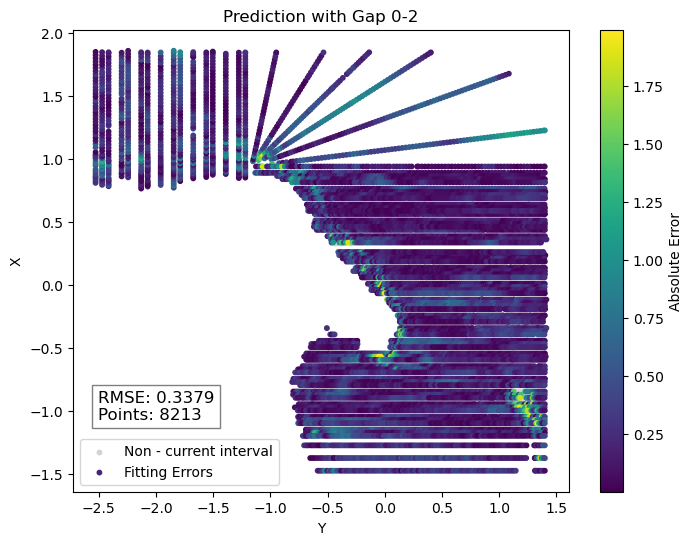

RMSE for gap 0-3: 0.3615


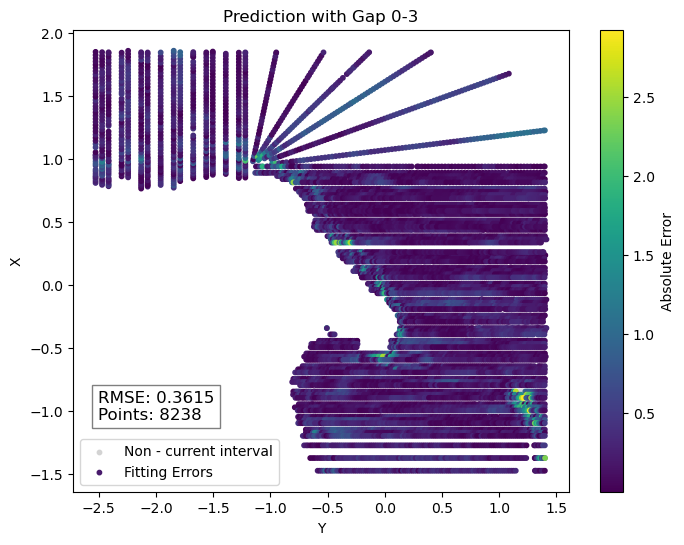

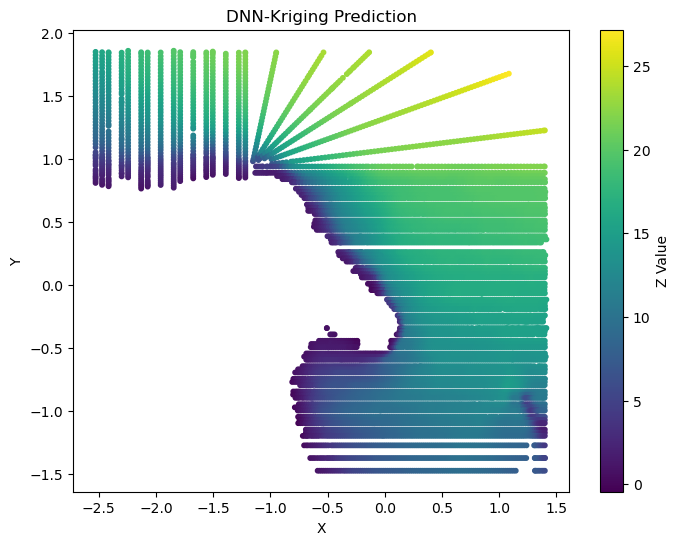

In [ ]:
#1992_interpolation
import sklearn
print(sklearn.__version__)
import sys
print(sys.executable)
import pandas as pd
import numpy as np
import tensorflow as tf
import random
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import pickle


# 设置随机种子
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# 1. 数据准备
def load_data(train_file, test_file):
    # 加载训练数据和测试数据
    train_data = pd.read_csv(train_file)
    test_data = pd.read_csv(test_file)

    # 提取 X, Y, Z 列
    X_train = train_data[['X', 'Y']].values
    Z_train = train_data['水深'].values

    X_test = test_data[['X', 'Y']].values
    # 若测试集无 Z 值，返回 None
    Z_test = None if '水深' not in test_data.columns else test_data['水深'].values

    return X_train, Z_train, X_test, Z_test

# 2. 数据预处理
def preprocess_data(X_train, Z_train, X_test, Z_test):
    # 标准化 X 和 Z 值
    scaler_X = StandardScaler()
    scaler_Z = StandardScaler()

    X_train = scaler_X.fit_transform(X_train)
    if Z_train is not None:
        Z_train = scaler_Z.fit_transform(Z_train.reshape(-1, 1)).flatten()

    X_test = scaler_X.transform(X_test)
    if Z_test is not None:
        Z_test = scaler_Z.transform(Z_test.reshape(-1, 1)).flatten()

    return X_train, Z_train, X_test, Z_test, scaler_X, scaler_Z

# 3. 构建 DNN 模型
def build_dnn(input_dim, hidden_layers=[ 1000,1000,1000]):
    model = Sequential()
    model.add(Dense(hidden_layers[0], activation='relu', input_dim=input_dim))
    model.add(Dropout(0.2))  # 添加 Dropout 层防止过拟合
    for units in hidden_layers[1:]:
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))  # 输出层
    return model

# 学习率调度函数
def lr_scheduler(epoch, lr):
    if epoch % 50 == 0 and epoch > 0:
        return lr * 0.1
    return lr

# 4. 训练 DNN 模型
def train_dnn(X_train, Z_train):
    # 构建 DNN 模型
    dnn_model = build_dnn(input_dim=2)
    optimizer = Adam(learning_rate=0.001)
    dnn_model.compile(optimizer=optimizer, loss='mse')

    # 定义学习率调度器
    lr_callback = LearningRateScheduler(lr_scheduler)

    # 记录训练集和验证集的损失值
    history = dnn_model.fit(
        x=X_train,
        y=Z_train,
        epochs=150,  # 增加训练轮数
        batch_size=64,
        validation_split=0.2,
        verbose=1,
        callbacks=[lr_callback]
    )

    # 绘制学习曲线
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Learning Curve')
    plt.legend()
    plt.show()

    return dnn_model

from sklearn.gaussian_process.kernels import Kernel, Hyperparameter
from sklearn.gaussian_process.kernels import ConstantKernel as C, ExpSineSquared

class ExponentialKernel(Kernel):
    def __init__(self, length_scale=1.0, length_scale_bounds=(1e-5, 1e5)):
        self.length_scale = length_scale
        self.length_scale_bounds = length_scale_bounds

    def __call__(self, X, Y, eval_gradient=False):
        X = np.asarray(X)
        Y = np.asarray(Y)
        D = cdist(X, Y, metric='euclidean')
        K = np.exp(-D / self.length_scale)
        if eval_gradient:
            if self.hyperparameter_length_scale.fixed:
                return K, np.empty((X.shape[0], Y.shape[0], 0))
            else:
                grad = K * (D / self.length_scale ** 2)
                return K, grad[:, :, np.newaxis]
        else:
            return K

    @property
    def hyperparameter_length_scale(self):
        return Hyperparameter("length_scale", "numeric", self.length_scale_bounds)

    def diag(self, X):
        return np.ones(X.shape[0])

    def is_stationary(self):
        return True

# 6. 克里金建模
def fit_kriging(X_train, residuals):
    # 定义克里金模型
    kernel = ExponentialKernel(length_scale=1.0, length_scale_bounds=(1e-2, 1e4))
    kriging_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-10)

    # 拟合克里金模型
    kriging_model.fit(X_train, residuals)
    return kriging_model

# 7. 预测与评估
def predict_and_evaluate(dnn_model, kriging_model, X_test, Z_test, scaler_Z, test_file):
    test_data = pd.read_csv(test_file)
    chunk_size = 10000  # 可以根据实际情况调整分块大小
    new_file_path = test_file.replace('.csv', '_pre.csv')
    header_written = False

    all_Z_pred_chunk = []  # 用于存储所有数据块的预测结果
    all_errors = []  # 用于存储所有数据块的误差

    for i in range(0, len(X_test), chunk_size):
        chunk_X_test = X_test[i:i + chunk_size]
        # 使用 DNN 模型预测 Z 值
        Z_pred_dnn = dnn_model.predict(chunk_X_test).flatten()
        # 使用克里金模型预测残差
        residuals_pred_kriging = kriging_model.predict(chunk_X_test)
        # 最终预测值
        Z_pred_chunk = Z_pred_dnn + residuals_pred_kriging
        Z_pred_chunk = scaler_Z.inverse_transform(Z_pred_chunk.reshape(-1, 1)).flatten()

        all_Z_pred_chunk.extend(Z_pred_chunk)  # 将当前数据块的预测结果添加到列表中

        chunk_test_data = test_data.iloc[i:i + chunk_size].copy()
        chunk_test_data['Predicted_Z'] = Z_pred_chunk

        if not header_written:
            chunk_test_data.to_csv(new_file_path, index=False)
            header_written = True
        else:
            chunk_test_data.to_csv(new_file_path, mode='a', index=False, header=False)

        if Z_test is not None:
            chunk_Z_test = Z_test[i:i + chunk_size]
            chunk_Z_test = scaler_Z.inverse_transform(chunk_Z_test.reshape(-1, 1)).flatten()
            chunk_errors = np.abs(chunk_Z_test - Z_pred_chunk)
            all_errors.extend(chunk_errors)

    Z_pred_chunk = np.array(all_Z_pred_chunk)  # 将所有数据块的预测结果转换为数组
    all_errors = np.array(all_errors)

    if Z_test is not None:
        Z_test = scaler_Z.inverse_transform(Z_test.reshape(-1, 1)).flatten()
        # 计算 RMSE 和 MAE
        rmse = np.sqrt(mean_squared_error(Z_test, Z_pred_chunk))
        mae = mean_absolute_error(Z_test, Z_pred_chunk)
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")

        # 可视化预测值与真实值的散点图
        plt.figure(figsize=(6, 6))
        plt.scatter(Z_test, Z_pred_chunk, s=5)
        plt.xlabel('True Values')
        plt.ylabel('Predicted Values')
        plt.title('True vs Predicted Values')
        # 绘制 y = x 直线
        min_val = min(np.min(Z_test), np.min(Z_pred_chunk))
        max_val = max(np.max(Z_test), np.max(Z_pred_chunk))
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')
        plt.text(0.05, 0.15, f'RMSE: {rmse:.4f}', transform=plt.gca().transAxes, fontsize=12,
                 verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.5))
        plt.legend()
        plt.show()

        # 可视化拟合效果分布
        max_error = np.max(all_errors)
        num_intervals = int(np.ceil(max_error)) + 1

        for i in range(num_intervals):
            if i == 0:
                lower_bound = 0
                upper_bound = 1
            elif i > 1:
                lower_bound = i - 1
                upper_bound = i
            else:
                continue

            current_mask = (all_errors >= lower_bound) & (all_errors < upper_bound)
            non_current_mask = ~current_mask

            current_errors = all_errors[current_mask]
            rmse_interval = np.sqrt(mean_squared_error(Z_test[current_mask], Z_pred_chunk[current_mask]))
            num_points = np.sum(current_mask)

            norm = plt.Normalize(vmin=lower_bound, vmax=upper_bound)
            cmap = plt.get_cmap('viridis')
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])

            plt.figure(figsize=(8, 6))
            plt.scatter(X_test[non_current_mask, 1], X_test[non_current_mask, 0], c='lightgray', s=10, label='Non - current interval')
            scatter = plt.scatter(X_test[current_mask, 1], X_test[current_mask, 0], c=current_errors, cmap=cmap, norm=norm, label='Fitting Errors', s=10)
            cbar = plt.colorbar(scatter)
            cbar.set_label('Absolute Error')
            plt.xlabel('Y')
            plt.ylabel('X')
            plt.title(f'Fitting Error Distribution ({lower_bound}-{upper_bound})')
            plt.text(0.05, 0.15, f'RMSE: {rmse_interval:.4f}\nPoints: {num_points}', transform=plt.gca().transAxes, fontsize=12,
                     verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.5))
            plt.legend()
            plt.show()

        # 额外绘制与真实值差距在0-2区间的图，并计算这些点对应的RMSE
        gap_mask_0_2 = (all_errors >= 0) & (all_errors < 2)
        X_test_gap_0_2 = X_test[gap_mask_0_2]
        Z_test_gap_0_2 = Z_test[gap_mask_0_2]
        Z_pred_chunk_gap_0_2 = Z_pred_chunk[gap_mask_0_2]

        rmse_gap_0_2 = np.sqrt(mean_squared_error(Z_test_gap_0_2, Z_pred_chunk_gap_0_2))
        num_points_0_2 = np.sum(gap_mask_0_2)
        print(f"RMSE for gap 0-2: {rmse_gap_0_2:.4f}")

        plt.figure(figsize=(8, 6))
        plt.scatter(X_test[~gap_mask_0_2, 1], X_test[~gap_mask_0_2, 0], c='lightgray', s=10, label='Non - current interval')
        scatter = plt.scatter(X_test_gap_0_2[:, 1], X_test_gap_0_2[:, 0], c=all_errors[gap_mask_0_2], cmap='viridis', label='Fitting Errors', s=10)
        cbar = plt.colorbar(scatter)
        cbar.set_label('Absolute Error')
        plt.xlabel('Y')
        plt.ylabel('X')
        plt.title('Prediction with Gap 0-2')
        plt.text(0.05, 0.15, f'RMSE: {rmse_gap_0_2:.4f}\nPoints: {num_points_0_2}', transform=plt.gca().transAxes, fontsize=12,
                 verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.5))
        plt.legend()
        plt.show()

        # 额外绘制与真实值差距在0-3区间的图，并计算这些点对应的RMSE
        gap_mask = (all_errors >= 0) & (all_errors < 3)
        X_test_gap = X_test[gap_mask]
        Z_test_gap = Z_test[gap_mask]
        Z_pred_chunk_gap = Z_pred_chunk[gap_mask]

        rmse_gap = np.sqrt(mean_squared_error(Z_test_gap, Z_pred_chunk_gap))
        num_points_0_3 = np.sum(gap_mask)
        print(f"RMSE for gap 0-3: {rmse_gap:.4f}")

        plt.figure(figsize=(8, 6))
        plt.scatter(X_test[~gap_mask, 1], X_test[~gap_mask, 0], c='lightgray', s=10, label='Non - current interval')
        scatter = plt.scatter(X_test_gap[:, 1], X_test_gap[:, 0], c=all_errors[gap_mask], cmap='viridis', label='Fitting Errors', s=10)
        cbar = plt.colorbar(scatter)
        cbar.set_label('Absolute Error')
        plt.xlabel('Y')
        plt.ylabel('X')
        plt.title('Prediction with Gap 0-3')
        plt.text(0.05, 0.15, f'RMSE: {rmse_gap:.4f}\nPoints: {num_points_0_3}', transform=plt.gca().transAxes, fontsize=12,
                 verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.5))
        plt.legend()
        plt.show()
    else:
        print("测试集无真实 Z 值，无法计算 RMSE 和 MAE,也无法绘制散点图和拟合效果分布图。")

    return Z_pred_chunk

# 8. 主函数
def main(train_file, test_file, save_models_flag=True, use_saved_models=False):
    if use_saved_models:
        dnn_path = 'E:/Desktop/duozhong/model_3km/dnn_model_1992.h5'
        kriging_path = 'E:/Desktop/duozhong/model_3km/kriging_model_1992.pkl'
        scaler_X_path = 'E:/Desktop/duozhong/model_3km/scaler_X_1992.pkl'
        scaler_Z_path = 'E:/Desktop/duozhong/model_3km/scaler_Z_1992.pkl'

        # 这里原代码中 load_models 函数未定义，需要补充
        def load_models(dnn_path, kriging_path, scaler_X_path, scaler_Z_path):
            dnn_model = load_model(dnn_path)
            with open(kriging_path, 'rb') as f:
                kriging_model = pickle.load(f)
            with open(scaler_X_path, 'rb') as f:
                scaler_X = pickle.load(f)
            with open(scaler_Z_path, 'rb') as f:
                scaler_Z = pickle.load(f)
            return dnn_model, kriging_model, scaler_X, scaler_Z

        dnn_model, kriging_model, scaler_X, scaler_Z = load_models(dnn_path, kriging_path, scaler_X_path, scaler_Z_path)

        # 加载新的测试数据
        _, _, X_test, Z_test = load_data(train_file, test_file)
        # 使用之前保存的 scaler_X 对 X_test 进行标准化
        X_test = scaler_X.transform(X_test)
        if Z_test is not None:
            # 使用之前保存的 scaler_Z 对 Z_test 进行标准化
            Z_test = scaler_Z.transform(Z_test.reshape(-1, 1)).flatten()
    else:

        # 数据准备
        X_train, Z_train, X_test, Z_test = load_data(train_file, test_file)

        # 数据预处理
        X_train, Z_train, X_test, Z_test, scaler_X, scaler_Z = preprocess_data(X_train, Z_train, X_test, Z_test)

        # 训练 DNN 模型
        dnn_model = train_dnn(X_train, Z_train)

        # 计算残差
        Z_pred_dnn_train = dnn_model.predict(X_train).flatten()
        residuals = Z_train - Z_pred_dnn_train

        # 拟合克里金模型
        kriging_model = fit_kriging(X_train, residuals)

        if save_models_flag:
            dnn_path = 'E:/Desktop/duozhong/model_3km/dnn_model_1992.h5'
            kriging_path = 'E:/Desktop/duozhong/model_3km/kriging_model_1992.pkl'
            scaler_X_path = 'E:/Desktop/duozhong/model_3km/scaler_X_1992.pkl'
            scaler_Z_path = 'E:/Desktop/duozhong/model_3km/scaler_Z_1992.pkl'

            def save_models(dnn_model, kriging_model, scaler_X, scaler_Z, dnn_path, kriging_path, scaler_X_path, scaler_Z_path):
                dnn_model.save(dnn_path)
                with open(kriging_path, 'wb') as f:
                    pickle.dump(kriging_model, f)
                with open(scaler_X_path, 'wb') as f:
                    pickle.dump(scaler_X, f)
                with open(scaler_Z_path, 'wb') as f:
                    pickle.dump(scaler_Z, f)

            save_models(dnn_model, kriging_model, scaler_X, scaler_Z, dnn_path, kriging_path, scaler_X_path, scaler_Z_path)

    # 预测与评估
    Z_pred_final = predict_and_evaluate(dnn_model, kriging_model, X_test, Z_test, scaler_Z, test_file)

    # 可视化结果（可选）
    plt.figure(figsize=(8, 6))
    plt.scatter(X_test[:, 1], X_test[:, 0], c=Z_pred_final, cmap='viridis', label='Predicted Values', s=10)  # 交换了 X 和 Y 的坐标
    plt.colorbar(label='Z Value')
    plt.xlabel('X')  # 更新了 x 轴标签
    plt.ylabel('Y')  # 更新了 y 轴标签
    plt.title('DNN-Kriging Prediction')
    plt.show()


# 9. 运行主函数
if __name__ == "__main__":
    train_file = 'E:/Desktop/duozhong/b_bisheng2/csv/1992_5km.csv'  # 替换为你的训练数据文件路径
    test_file = 'E:/Desktop/duozhong/b_bisheng2/csv/1992_3km.csv'
    # 第一次运行时，use_saved_models 设为 False，保存模型
    # 后续运行时，use_saved_models 设为 True，使用保存的模型
    main(train_file, test_file, save_models_flag=True, use_saved_models=False)

#1992_5km 

1.3.2
d:\anaconda\envs\pytorch\python.exe
161/161 [==============================] - 1s 2ms/step
RMSE: 1.8454
MAE: 0.9655


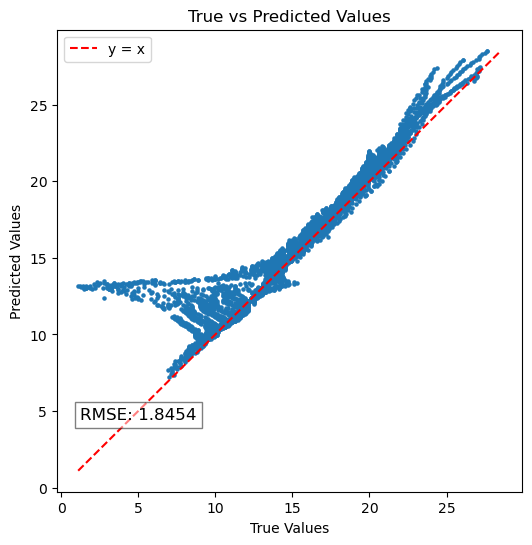

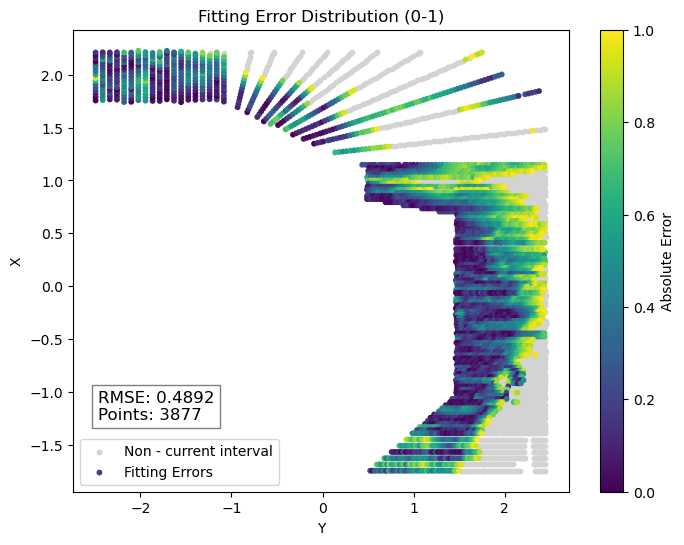

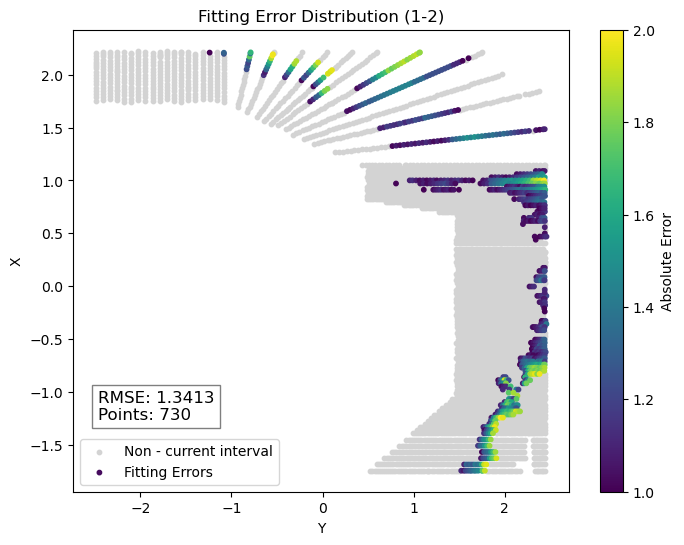

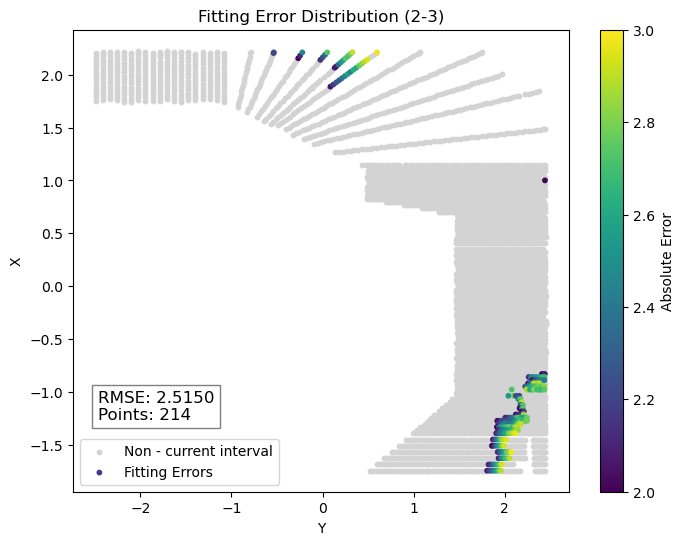

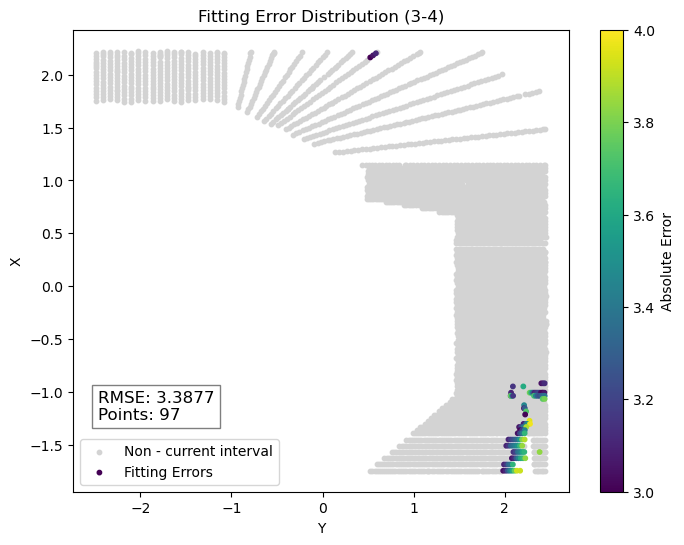

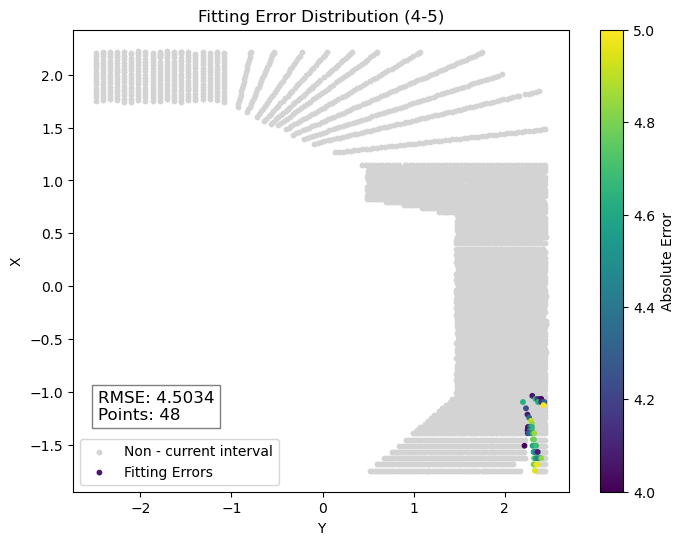

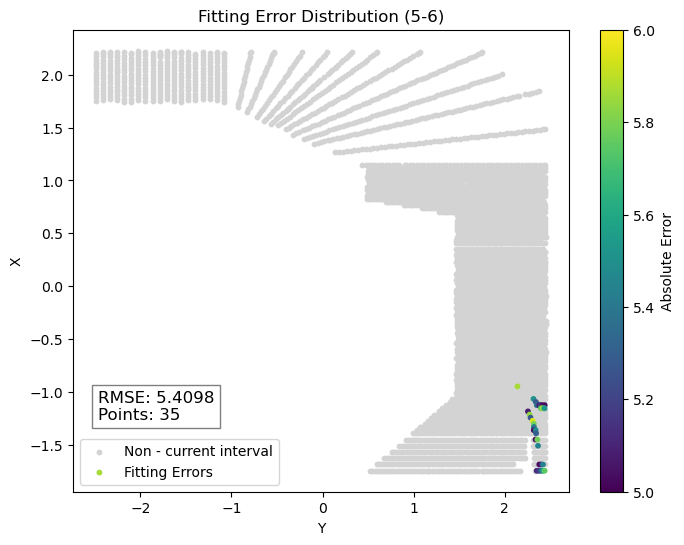

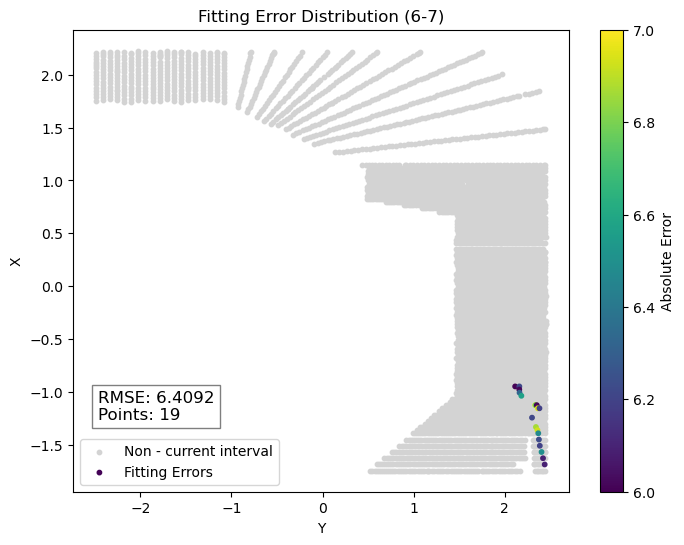

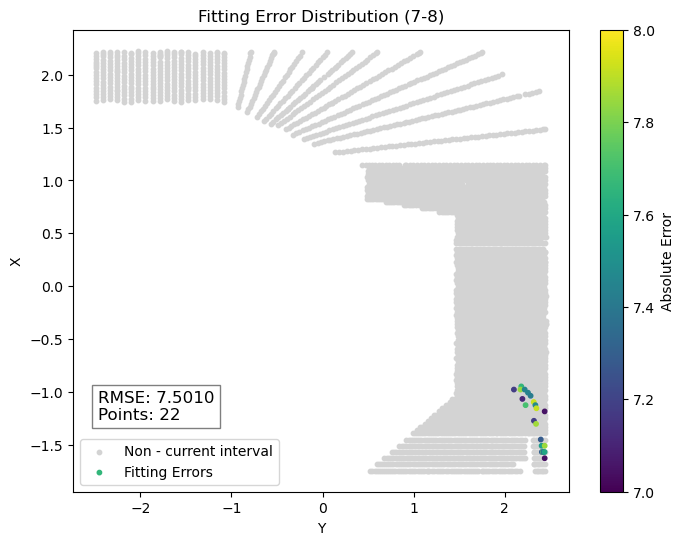

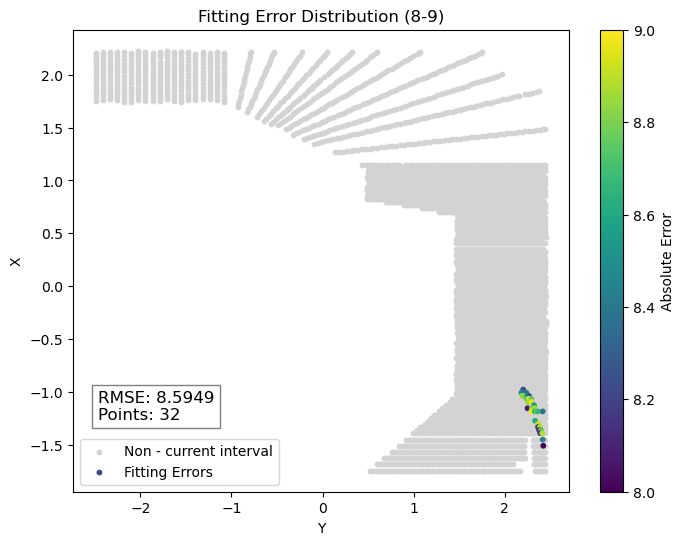

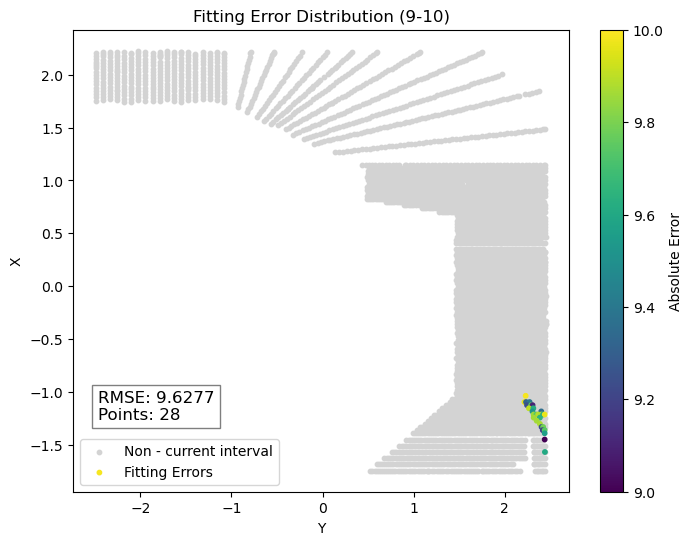

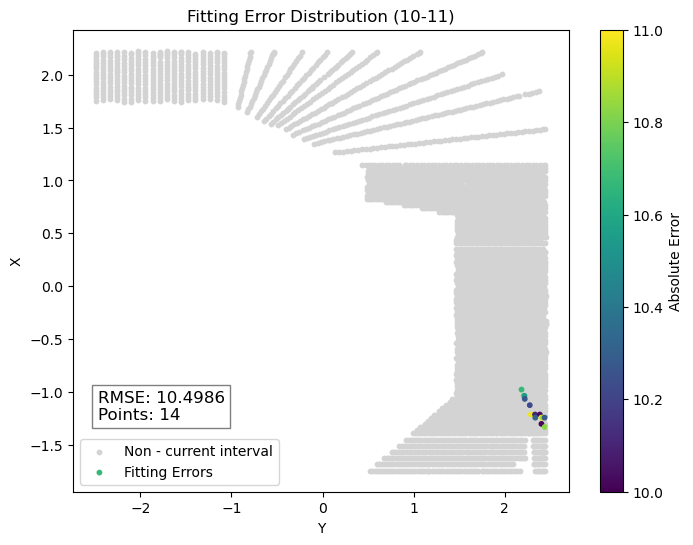

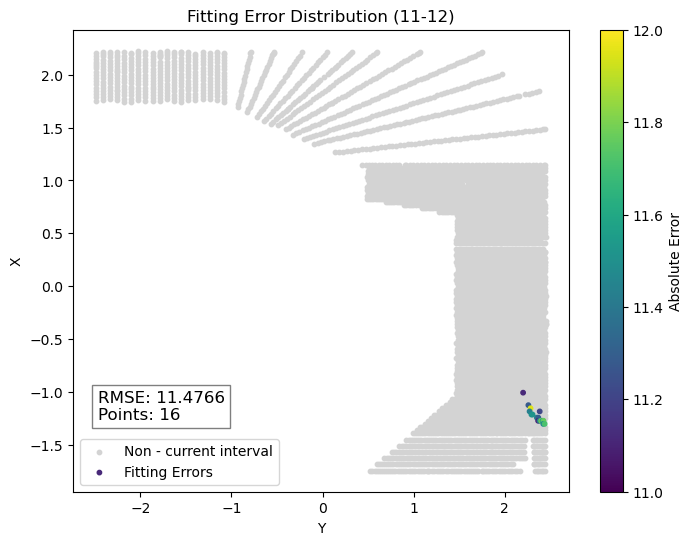

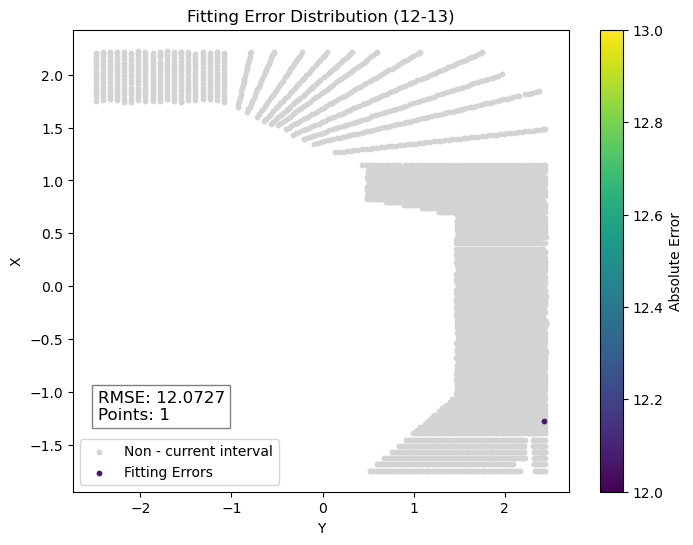

RMSE for gap 0-2: 0.6975


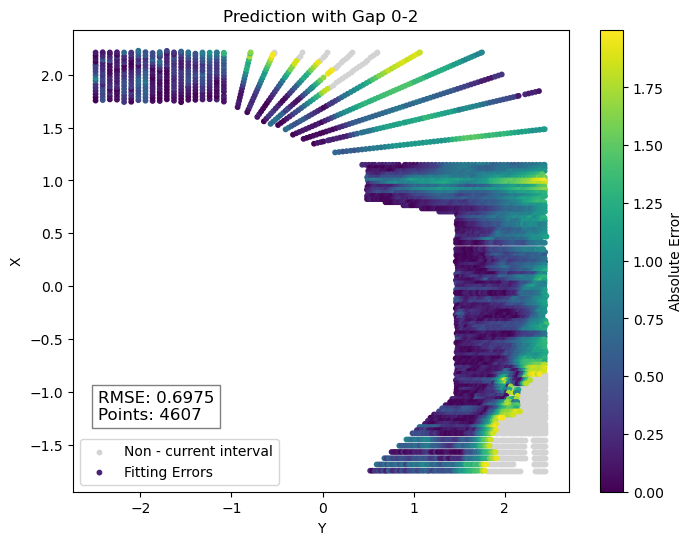

RMSE for gap 0-3: 0.8635


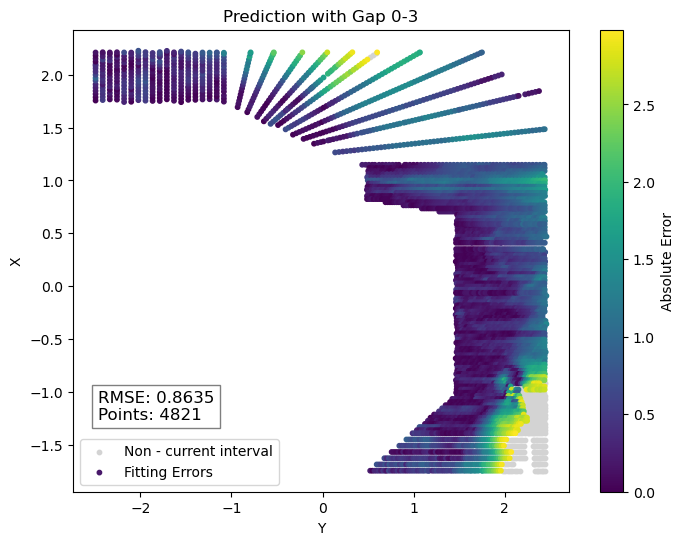

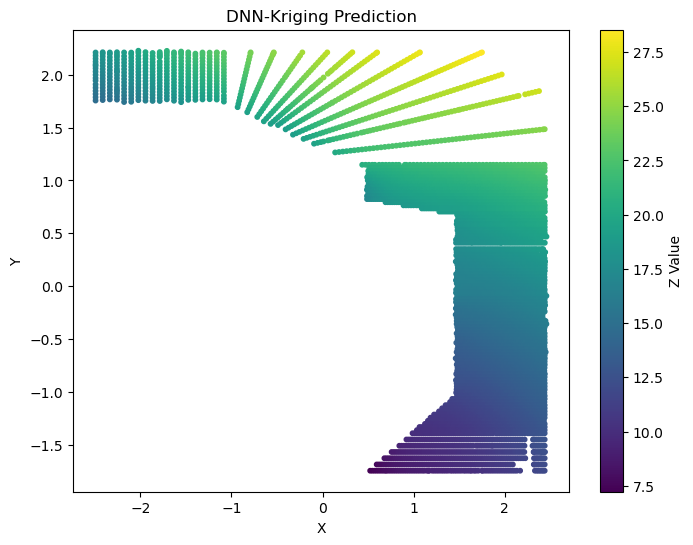

In [ ]:
#1992_extrapolation
import sklearn
print(sklearn.__version__)
import sys
print(sys.executable)
import pandas as pd
import numpy as np
import tensorflow as tf
import random
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import pickle


# 设置随机种子
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# 1. 数据准备
def load_data(train_file, test_file):
    # 加载训练数据和测试数据
    train_data = pd.read_csv(train_file)
    test_data = pd.read_csv(test_file)

    # 提取 X, Y, Z 列
    X_train = train_data[['X', 'Y']].values
    Z_train = train_data['水深'].values

    X_test = test_data[['X', 'Y']].values
    # 若测试集无 Z 值，返回 None
    Z_test = None if '水深' not in test_data.columns else test_data['水深'].values

    return X_train, Z_train, X_test, Z_test

# 2. 数据预处理
def preprocess_data(X_train, Z_train, X_test, Z_test):
    # 标准化 X 和 Z 值
    scaler_X = StandardScaler()
    scaler_Z = StandardScaler()

    X_train = scaler_X.fit_transform(X_train)
    if Z_train is not None:
        Z_train = scaler_Z.fit_transform(Z_train.reshape(-1, 1)).flatten()

    X_test = scaler_X.transform(X_test)
    if Z_test is not None:
        Z_test = scaler_Z.transform(Z_test.reshape(-1, 1)).flatten()

    return X_train, Z_train, X_test, Z_test, scaler_X, scaler_Z

# 3. 构建 DNN 模型
def build_dnn(input_dim, hidden_layers=[256,128,64,64,64,64]):
    model = Sequential()
    model.add(Dense(hidden_layers[0], activation='relu', input_dim=input_dim))
    model.add(Dropout(0.4))  # 添加 Dropout 层防止过拟合
    for units in hidden_layers[1:]:
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(0.4))
    model.add(Dense(1, activation='linear'))  # 输出层
    return model

# 学习率调度函数
def lr_scheduler(epoch, lr):
    if epoch % 50 == 0 and epoch > 0:
        return lr * 0.1
    return lr

# 4. 训练 DNN 模型
def train_dnn(X_train, Z_train):
    # 构建 DNN 模型
    dnn_model = build_dnn(input_dim=2)
    optimizer = Adam(learning_rate=0.00037)
    dnn_model.compile(optimizer=optimizer, loss='mse')

    # 定义学习率调度器
    lr_callback = LearningRateScheduler(lr_scheduler)

    # 记录训练集和验证集的损失值
    history = dnn_model.fit(
        x=X_train,
        y=Z_train,
        epochs=150,  # 增加训练轮数
        batch_size=64,
        validation_split=0.2,
        verbose=1,
        callbacks=[lr_callback]
    )

    # 绘制学习曲线
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Learning Curve')
    plt.legend()
    plt.show()

    return dnn_model

from sklearn.gaussian_process.kernels import Kernel, Hyperparameter
from sklearn.gaussian_process.kernels import ConstantKernel as C, ExpSineSquared

class ExponentialKernel(Kernel):
    def __init__(self, length_scale=1.0, length_scale_bounds=(1e-5, 1e5)):
        self.length_scale = length_scale
        self.length_scale_bounds = length_scale_bounds

    def __call__(self, X, Y=None, eval_gradient=False):
        X = np.asarray(X)
        Y = X if Y is None else np.asarray(Y)
        D = cdist(X, Y, metric='euclidean')
        K = np.exp(-D / self.length_scale)
        if eval_gradient:
            if self.hyperparameter_length_scale.fixed:
                return K, np.empty((X.shape[0], Y.shape[0], 0))
            else:
                grad = K * (D / self.length_scale ** 2)
                return K, grad[:, :, np.newaxis]
        else:
            return K

    @property
    def hyperparameter_length_scale(self):
        return Hyperparameter("length_scale", "numeric", self.length_scale_bounds)

    def diag(self, X):
        return np.ones(X.shape[0])

    def is_stationary(self):
        return True

# 6. 克里金建模
def fit_kriging(X_train, residuals):
    # 定义克里金模型
    kernel = ExponentialKernel(length_scale=1.0, length_scale_bounds=(1e-2, 1e4))
    kriging_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-10)

    # 拟合克里金模型
    kriging_model.fit(X_train, residuals)
    return kriging_model

# 7. 预测与评估
def predict_and_evaluate(dnn_model, kriging_model, X_test, Z_test, scaler_Z, test_file):
    test_data = pd.read_csv(test_file)
    chunk_size = 10000  # 可以根据实际情况调整分块大小
    new_file_path = test_file.replace('.csv', '_pre.csv')
    header_written = False

    all_Z_pred_chunk = []  # 用于存储所有数据块的预测结果
    all_errors = []  # 用于存储所有数据块的误差

    for i in range(0, len(X_test), chunk_size):
        chunk_X_test = X_test[i:i + chunk_size]
        # 使用 DNN 模型预测 Z 值
        Z_pred_dnn = dnn_model.predict(chunk_X_test).flatten()
        # 使用克里金模型预测残差
        residuals_pred_kriging = kriging_model.predict(chunk_X_test)
        # 最终预测值
        Z_pred_chunk = Z_pred_dnn + residuals_pred_kriging
        Z_pred_chunk = scaler_Z.inverse_transform(Z_pred_chunk.reshape(-1, 1)).flatten()

        all_Z_pred_chunk.extend(Z_pred_chunk)  # 将当前数据块的预测结果添加到列表中

        chunk_test_data = test_data.iloc[i:i + chunk_size].copy()
        chunk_test_data['Predicted_Z'] = Z_pred_chunk

        if not header_written:
            chunk_test_data.to_csv(new_file_path, index=False)
            header_written = True
        else:
            chunk_test_data.to_csv(new_file_path, mode='a', index=False, header=False)

        if Z_test is not None:
            chunk_Z_test = Z_test[i:i + chunk_size]
            chunk_Z_test = scaler_Z.inverse_transform(chunk_Z_test.reshape(-1, 1)).flatten()
            chunk_errors = np.abs(chunk_Z_test - Z_pred_chunk)
            all_errors.extend(chunk_errors)

    Z_pred_chunk = np.array(all_Z_pred_chunk)  # 将所有数据块的预测结果转换为数组
    all_errors = np.array(all_errors)

    if Z_test is not None:
        Z_test = scaler_Z.inverse_transform(Z_test.reshape(-1, 1)).flatten()
        # 计算 RMSE 和 MAE
        rmse = np.sqrt(mean_squared_error(Z_test, Z_pred_chunk))
        mae = mean_absolute_error(Z_test, Z_pred_chunk)
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")

        # 可视化预测值与真实值的散点图
        plt.figure(figsize=(6, 6))
        plt.scatter(Z_test, Z_pred_chunk, s=5)
        plt.xlabel('True Values')
        plt.ylabel('Predicted Values')
        plt.title('True vs Predicted Values')
        # 绘制 y = x 直线
        min_val = min(np.min(Z_test), np.min(Z_pred_chunk))
        max_val = max(np.max(Z_test), np.max(Z_pred_chunk))
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')
        plt.text(0.05, 0.15, f'RMSE: {rmse:.4f}', transform=plt.gca().transAxes, fontsize=12,
                 verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.5))
        plt.legend()
        plt.show()

        # 可视化拟合效果分布
        max_error = np.max(all_errors)
        num_intervals = int(np.ceil(max_error)) + 1

        for i in range(num_intervals):
            if i == 0:
                lower_bound = 0
                upper_bound = 1
            elif i > 1:
                lower_bound = i - 1
                upper_bound = i
            else:
                continue

            current_mask = (all_errors >= lower_bound) & (all_errors < upper_bound)
            non_current_mask = ~current_mask

            current_errors = all_errors[current_mask]
            rmse_interval = np.sqrt(mean_squared_error(Z_test[current_mask], Z_pred_chunk[current_mask]))
            num_points = np.sum(current_mask)

            norm = plt.Normalize(vmin=lower_bound, vmax=upper_bound)
            cmap = plt.get_cmap('viridis')
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])

            plt.figure(figsize=(8, 6))
            plt.scatter(X_test[non_current_mask, 1], X_test[non_current_mask, 0], c='lightgray', s=10, label='Non - current interval')
            scatter = plt.scatter(X_test[current_mask, 1], X_test[current_mask, 0], c=current_errors, cmap=cmap, norm=norm, label='Fitting Errors', s=10)
            cbar = plt.colorbar(scatter)
            cbar.set_label('Absolute Error')
            plt.xlabel('Y')
            plt.ylabel('X')
            plt.title(f'Fitting Error Distribution ({lower_bound}-{upper_bound})')
            plt.text(0.05, 0.15, f'RMSE: {rmse_interval:.4f}\nPoints: {num_points}', transform=plt.gca().transAxes, fontsize=12,
                     verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.5))
            plt.legend()
            plt.show()

        # 额外绘制与真实值差距在0-2区间的图，并计算这些点对应的RMSE
        gap_mask_0_2 = (all_errors >= 0) & (all_errors < 2)
        X_test_gap_0_2 = X_test[gap_mask_0_2]
        Z_test_gap_0_2 = Z_test[gap_mask_0_2]
        Z_pred_chunk_gap_0_2 = Z_pred_chunk[gap_mask_0_2]

        rmse_gap_0_2 = np.sqrt(mean_squared_error(Z_test_gap_0_2, Z_pred_chunk_gap_0_2))
        num_points_0_2 = np.sum(gap_mask_0_2)
        print(f"RMSE for gap 0-2: {rmse_gap_0_2:.4f}")

        plt.figure(figsize=(8, 6))
        plt.scatter(X_test[~gap_mask_0_2, 1], X_test[~gap_mask_0_2, 0], c='lightgray', s=10, label='Non - current interval')
        scatter = plt.scatter(X_test_gap_0_2[:, 1], X_test_gap_0_2[:, 0], c=all_errors[gap_mask_0_2], cmap='viridis', label='Fitting Errors', s=10)
        cbar = plt.colorbar(scatter)
        cbar.set_label('Absolute Error')
        plt.xlabel('Y')
        plt.ylabel('X')
        plt.title('Prediction with Gap 0-2')
        plt.text(0.05, 0.15, f'RMSE: {rmse_gap_0_2:.4f}\nPoints: {num_points_0_2}', transform=plt.gca().transAxes, fontsize=12,
                 verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.5))
        plt.legend()
        plt.show()

        # 额外绘制与真实值差距在0-3区间的图，并计算这些点对应的RMSE
        gap_mask = (all_errors >= 0) & (all_errors < 3)
        X_test_gap = X_test[gap_mask]
        Z_test_gap = Z_test[gap_mask]
        Z_pred_chunk_gap = Z_pred_chunk[gap_mask]

        rmse_gap = np.sqrt(mean_squared_error(Z_test_gap, Z_pred_chunk_gap))
        num_points_0_3 = np.sum(gap_mask)
        print(f"RMSE for gap 0-3: {rmse_gap:.4f}")

        plt.figure(figsize=(8, 6))
        plt.scatter(X_test[~gap_mask, 1], X_test[~gap_mask, 0], c='lightgray', s=10, label='Non - current interval')
        scatter = plt.scatter(X_test_gap[:, 1], X_test_gap[:, 0], c=all_errors[gap_mask], cmap='viridis', label='Fitting Errors', s=10)
        cbar = plt.colorbar(scatter)
        cbar.set_label('Absolute Error')
        plt.xlabel('Y')
        plt.ylabel('X')
        plt.title('Prediction with Gap 0-3')
        plt.text(0.05, 0.15, f'RMSE: {rmse_gap:.4f}\nPoints: {num_points_0_3}', transform=plt.gca().transAxes, fontsize=12,
                 verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.5))
        plt.legend()
        plt.show()
    else:
        print("测试集无真实 Z 值，无法计算 RMSE 和 MAE,也无法绘制散点图和拟合效果分布图。")

    return Z_pred_chunk

# 8. 主函数
def main(train_file, test_file, save_models_flag=True, use_saved_models=False):
    if use_saved_models:
        dnn_path = 'E:/Desktop/duozhong/model_tu/dnn_model_1992.h5'
        kriging_path = 'E:/Desktop/duozhong/model_tu/kriging_model_1992.pkl'
        scaler_X_path = 'E:/Desktop/duozhong/model_tu/scaler_X_1992.pkl'
        scaler_Z_path = 'E:/Desktop/duozhong/model_tu/scaler_Z_1992.pkl'

        # 这里原代码中 load_models 函数未定义，需要补充
        def load_models(dnn_path, kriging_path, scaler_X_path, scaler_Z_path):
            dnn_model = load_model(dnn_path)
            with open(kriging_path, 'rb') as f:
                kriging_model = pickle.load(f)
            with open(scaler_X_path, 'rb') as f:
                scaler_X = pickle.load(f)
            with open(scaler_Z_path, 'rb') as f:
                scaler_Z = pickle.load(f)
            return dnn_model, kriging_model, scaler_X, scaler_Z

        dnn_model, kriging_model, scaler_X, scaler_Z = load_models(dnn_path, kriging_path, scaler_X_path, scaler_Z_path)

        # 加载新的测试数据
        _, _, X_test, Z_test = load_data(train_file, test_file)
        # 使用之前保存的 scaler_X 对 X_test 进行标准化
        X_test = scaler_X.transform(X_test)
        if Z_test is not None:
            # 使用之前保存的 scaler_Z 对 Z_test 进行标准化
            Z_test = scaler_Z.transform(Z_test.reshape(-1, 1)).flatten()
    else:

        # 数据准备
        X_train, Z_train, X_test, Z_test = load_data(train_file, test_file)

        # 数据预处理
        X_train, Z_train, X_test, Z_test, scaler_X, scaler_Z = preprocess_data(X_train, Z_train, X_test, Z_test)

        # 训练 DNN 模型
        dnn_model = train_dnn(X_train, Z_train)

        # 计算残差
        Z_pred_dnn_train = dnn_model.predict(X_train).flatten()
        residuals = Z_train - Z_pred_dnn_train

        # 拟合克里金模型
        kriging_model = fit_kriging(X_train, residuals)

        if save_models_flag:
            dnn_path = 'E:/Desktop/duozhong/model_tu/dnn_model_1992.h5'
            kriging_path = 'E:/Desktop/duozhong/model_tu/kriging_model_1992.pkl'
            scaler_X_path = 'E:/Desktop/duozhong/model_tu/scaler_X_1992.pkl'
            scaler_Z_path = 'E:/Desktop/duozhong/model_tu/scaler_Z_1992.pkl'

            def save_models(dnn_model, kriging_model, scaler_X, scaler_Z, dnn_path, kriging_path, scaler_X_path, scaler_Z_path):
                dnn_model.save(dnn_path)
                with open(kriging_path, 'wb') as f:
                    pickle.dump(kriging_model, f)
                with open(scaler_X_path, 'wb') as f:
                    pickle.dump(scaler_X, f)
                with open(scaler_Z_path, 'wb') as f:
                    pickle.dump(scaler_Z, f)

            save_models(dnn_model, kriging_model, scaler_X, scaler_Z, dnn_path, kriging_path, scaler_X_path, scaler_Z_path)

    # 预测与评估
    Z_pred_final = predict_and_evaluate(dnn_model, kriging_model, X_test, Z_test, scaler_Z, test_file)

    # 可视化结果（可选）
    plt.figure(figsize=(8, 6))
    plt.scatter(X_test[:, 1], X_test[:, 0], c=Z_pred_final, cmap='viridis', label='Predicted Values', s=10)  # 交换了 X 和 Y 的坐标
    plt.colorbar(label='Z Value')
    plt.xlabel('X')  # 更新了 x 轴标签
    plt.ylabel('Y')  # 更新了 y 轴标签
    plt.title('DNN-Kriging Prediction')
    plt.show()


# 9. 运行主函数
if __name__ == "__main__":
    train_file = 'E:/Desktop/duozhong/b_bisheng2/csv/1992_nei.csv'  # 替换为你的训练数据文件路径
    test_file = 'E:/Desktop/duozhong/b_bisheng2/csv/1992_tu_mi.csv'
    # 第一次运行时，use_saved_models 设为 False，保存模型
    # 后续运行时，use_saved_models 设为 True，使用保存的模型
    main(train_file, test_file, save_models_flag=False, use_saved_models=True)

#1992_tu_mi